C:\Users\pc\Desktop\Graduation Project\GP-Epileptic-seizures\Z: Found 100 text files


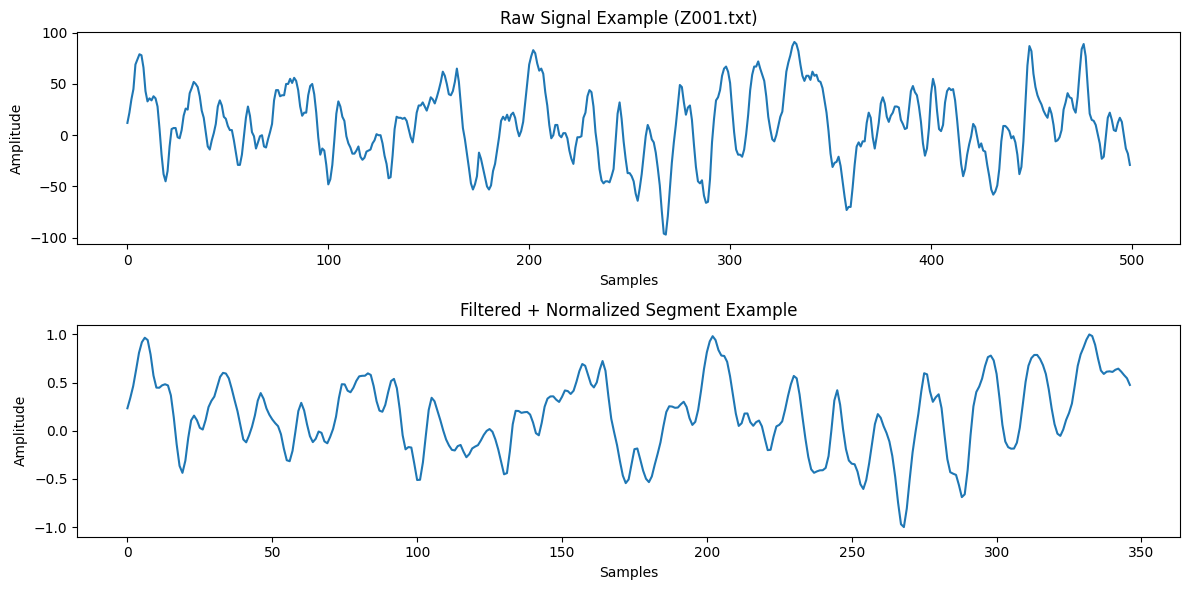

Saved NORMAL → (2200, 347) to NPY & TXT
C:\Users\pc\Desktop\Graduation Project\GP-Epileptic-seizures\O: Found 100 text files
Saved NORMAL → (2200, 347) to NPY & TXT
C:\Users\pc\Desktop\Graduation Project\GP-Epileptic-seizures\N: Found 100 text files
Saved INTERICTAL → (2200, 347) to NPY & TXT
C:\Users\pc\Desktop\Graduation Project\GP-Epileptic-seizures\F: Found 100 text files
Saved INTERICTAL → (2200, 347) to NPY & TXT
C:\Users\pc\Desktop\Graduation Project\GP-Epileptic-seizures\S: Found 100 text files
Saved ICTAL → (2200, 347) to NPY & TXT
All data merged and saved → X: (11000, 347), y: (11000,)
Preprocessing complete!


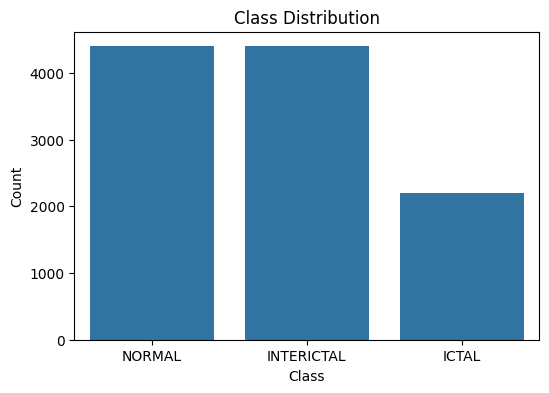


Class Counts:
ICTAL: 2200
INTERICTAL: 4400
NORMAL: 4400


In [5]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import savemat
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Bandpass Filter

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=173.61, order=5):
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Preprocessing Function

# def preprocess_signal(signal, fs=173.61, segment_length=None):
#     # Bandpass Filter
#     filtered = bandpass_filter(signal, 0.5, 50, fs)
#     # Segmentation
#     if segment_length is None:
#         segment_length = int(5 * fs)  # 5-second default
#     segments = []
#     for start in range(0, len(filtered), segment_length):
#         end = start + segment_length
#         if end <= len(filtered):
#             segments.append(filtered[start:end])
#     segments = np.array(segments)  # shape = (num_segments, segment_length)

#     # Normalization (Min–Max per segment)
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     normed_segments = np.zeros_like(segments)
#     for i in range(segments.shape[0]):
#         normed_segments[i] = scaler.fit_transform(segments[i].reshape(-1, 1)).flatten()

#     return normed_segments, filtered

def preprocess_signal(signal, fs=173.61):
    # 1) Bandpass Filter
    filtered = bandpass_filter(signal, 0.5, 50, fs)

    # 2) Windowing: 2 sec with 50% overlap
    window_length = int(2 * fs)       # 2 seconds → 347 samples
    step = window_length // 2         # 50% overlap → 173 samples

    segments = []
    for start in range(0, len(filtered) - window_length + 1, step):
        segment = filtered[start : start + window_length]
        segments.append(segment)

    segments = np.array(segments)  # shape: (num_segments, window_length)

    # 3) Min–Max Normalization per window
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normed_segments = np.zeros_like(segments)

    for i in range(segments.shape[0]):
        normed_segments[i] = scaler.fit_transform(
            segments[i].reshape(-1, 1)
        ).flatten()

    return normed_segments, filtered

# Load & Preprocess Dataset

def load_and_preprocess_bonn(root_dir, save_dir, plot_example=True):
    # Map folders to classes
    classes = {
        "Z": "NORMAL",
        "O": "NORMAL",
        "N": "INTERICTAL",
        "F": "INTERICTAL",
        "S": "ICTAL"
    }

    all_segments, all_labels = [], []
    plotted = False

    for folder, label in classes.items():
        folder_path = os.path.join(root_dir, folder)
        files = glob.glob(os.path.join(folder_path, "**", "*.txt"), recursive=True)

        print(f"{folder_path}: Found {len(files)} text files")

        class_segments = []
        for i, file in enumerate(files):
            try:
                data = np.loadtxt(file)
                normed_segments, filtered = preprocess_signal(data)

                # Plot one example
                if plot_example and not plotted:
                    plt.figure(figsize=(12, 6))
                    plt.subplot(2, 1, 1)
                    plt.plot(data[:500])
                    plt.title(f"Raw Signal Example ({os.path.basename(file)})")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")

                    plt.subplot(2, 1, 2)
                    plt.plot(normed_segments[0][:500])
                    plt.title("Filtered + Normalized Segment Example")
                    plt.xlabel("Samples")
                    plt.ylabel("Amplitude")
                    plt.tight_layout()
                    plt.show()
                    plotted = True

                class_segments.append(normed_segments)
            except Exception as e:
                print(f"Error reading {file}: {e}")

        if not class_segments:
            print(f"No valid data found for {folder}")
            continue

        class_segments = np.vstack(class_segments)
        labels = np.full(len(class_segments), label)
        all_segments.append(class_segments)
        all_labels.append(labels)

        # --- Save per class ---
        os.makedirs(save_dir, exist_ok=True)

        np.save(os.path.join(save_dir, f"{label}_X.npy"), class_segments)
        np.save(os.path.join(save_dir, f"{label}_y.npy"), labels)
        np.savetxt(os.path.join(save_dir, f"{label}_X.txt"), class_segments, fmt="%.6f")
        np.savetxt(os.path.join(save_dir, f"{label}_y.txt"), labels, fmt="%s")

        print(f"Saved {label} → {class_segments.shape} to NPY & TXT")

    # --- Merge all ---
    if not all_segments:
        raise RuntimeError("❌ No valid data loaded! Check folder paths or file format.")

    X = np.vstack(all_segments)
    y = np.concatenate(all_labels)

    np.save(os.path.join(save_dir, "ALL_X.npy"), X)
    np.save(os.path.join(save_dir, "ALL_y.npy"), y)
    np.savetxt(os.path.join(save_dir, "ALL_X.txt"), X, fmt="%.6f")
    np.savetxt(os.path.join(save_dir, "ALL_y.txt"), y, fmt="%s")

    print(f"All data merged and saved → X: {X.shape}, y: {y.shape}")

    return X, y

if __name__ == "__main__":
    root = r"C:\Users\pc\Desktop\Graduation Project\GP-Epileptic-seizures"
    save_dir = os.path.join(root, "preprocessed")

    X, y = load_and_preprocess_bonn(root, save_dir, plot_example=True)
    print("Preprocessing complete!")

   
    plt.figure(figsize=(6,4))
    sns.countplot(x=y)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

    # Optional: print exact numbers
    unique, counts = np.unique(y, return_counts=True)
    print("\nClass Counts:")
    for cls, cnt in zip(unique, counts):
        print(f"{cls}: {cnt}")
